In [1]:
import pandas as pd
import numpy as np
import datetime, time, os, gc, re, sys
from functools import partial
import matplotlib.pyplot as plt
from utils import ignore_warnings, load_data

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
train = load_data('train', nrows=1000000)
def fprint(df, name):
    print(f'{name} shape: ({df.shape[0]:,}, {df.shape[1]})')
    
fprint(train, 'raw train')
train = (train[(train['action_type'] == 'clickout item') & 
               (train['impressions'].notna()) & 
               (train['reference'].notna())]
         .reset_index(drop=True))

fprint(train, 'train after filtering')

[05-04 13:32:28 - utils - load_data - INFO] Loading train using 1,000,000 rows which is 0.06% out of total train data


raw train shape: (1,000,000, 12)
train after filtering shape: (99,872, 12)


In [3]:
# %%time
# # also get test
# test = load_data('test')#, nrows=1000000)
# fprint(test, 'raw test')
# test = test[(test.action_type == 'clickout item') & (test.impressions.notna()) & (test.reference.notna())].reset_index(drop=True)
# fprint(test, 'test after')

In [4]:
# train = pd.concat([train, test], ignore_index=True)
# del test
# gc.collect()

In [5]:
# drop duplciates of rows with all same info except step
cols = [c for c in train.columns if c != 'step']
train = train.drop_duplicates(subset=cols, keep='last').reset_index(drop=True)
fprint(train, 'after dropping duplicates')

after dropping duplicates shape: (99,382, 12)


In [6]:
# %%time
# def session_duration(x):
#     return x.max() - x.min()
# # session_fts = train.groupby('session_id').agg({'session_id': 'size', 'timestamp': session_duration})
# session_fts = train.groupby('session_id').size().reset_index(name='session_size')

In [7]:
# from clean_session import preprocess_sessions
# # train = preprocess_sessions(train,data_source='data')
# train = preprocess_sessions(None,data_source='data')

In [8]:
# %%time
# train_last = train.groupby('session_id').last().reset_index()

In [9]:
# train_last = train.copy()

In [10]:
# del train
# gc.collect()

In [11]:
# train_last = pd.merge(train_last, session_fts, on='session_id')
# fprint(train_last, 'train_last')

In [12]:
# fprint(train_last, 'train_last')

---

In [13]:
# get only common cities
city_counts = train['city'].value_counts()
city_counts_cs = city_counts.cumsum()/(city_counts.sum())
city_counts_cs.head()

London, United Kingdom    0.019400
Paris, France             0.033316
Tokyo, Japan              0.046065
New York, USA             0.057365
Istanbul, Turkey          0.067467
Name: city, dtype: float64

In [14]:
# set the threshold we select cities
th = 0.9
above_th = city_counts_cs[city_counts_cs<th]
common_cities = above_th.index.values
train = train[train['city'].isin(common_cities)].reset_index(drop=True)
fprint(train, 'train')

train shape: (89,442, 12)


In [15]:
# create a label see if it contains any sortings
train['no_reorder'] = train['current_filters'].str.contains(r'\b(sort|focus)', case=False)
train['no_reorder'].fillna(False, inplace=True)
# train['current_filters'].dropna()[train['current_filters'].dropna().str.contains(r'\bsort', case=False)].value_counts()

/Users/sam_dessa/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


In [16]:
# current filters
train['cfs'] = train['current_filters'].str.lower().str.split('|')
train['ncfs'] = train['cfs'].str.len()

In [17]:
# add country infomation
train['country'] = train.city.str.split(',').str[1]

In [18]:
# we add prices split now after shrink (otherwise prices being list cannot get shrinked)
# prices
train['prices'] = train.prices.str.split('|')
train['prices'] = train.prices.apply(lambda x: [int(p) for p in x])
# pad it
train['prices'] = train.prices.apply(lambda x: np.pad(x, (0, 25-len(x)), mode='constant'))

In [19]:
# number of impressions
train['nimps'] = train.impressions.str.split('|').str.len()

In [20]:
%%time
# impressions
train['impressions'] = train['impressions'].str.split('|')
# convert impression id to int
train['impressions'] = train['impressions'].apply(lambda x: [int(i) for i in x])
train['reference'] = train['reference'].astype(int)
# pad to 25 len
train['impressions'] = train['impressions'].apply(lambda x: np.pad(x, (0, 25-len(x)), mode='constant'))

CPU times: user 2.95 s, sys: 65.7 ms, total: 3.02 s
Wall time: 3.02 s


In [21]:
n_item_ids = len(set(np.concatenate(train['impressions'].values)))
n_item_ids

256663

In [22]:
# filter out nan rows with reference_id not in impressions list, since if the true target in test
# is not in the impression list then it would not get evaluated
def assign_target(row):
    ref = row['reference']
    imp = list(row['impressions'])
    if ref in imp:
        return imp.index(ref)
    else:
        return np.nan
train['target'] = train.apply(assign_target, axis=1)
fprint(train, 'train')

train shape: (89,442, 18)


In [23]:
print(f'drop number of rows reference id not in impressions list: {train.target.isna().sum()}')
# drop the ones whose reference is not in the impression list
train = train[train['target'].notna()].reset_index(drop=True)
train['target'] = train['target'].astype(int)
fprint(train, 'train')

drop number of rows reference id not in impressions list: 50
train shape: (89,392, 18)


In [24]:
# look at the target distribution
pd.value_counts(train['target']).head()

0    27506
1     9485
2     6716
3     5321
4     4686
Name: target, dtype: int64

---

In [25]:
meta_df = load_data('item_metadata')

In [26]:
meta_df.head()

,item_id,properties
0,5101,Satellite TV|Golf Course|Airport Shuttle|Cosme...
1,5416,Satellite TV|Cosmetic Mirror|Safe (Hotel)|Tele...
2,5834,Satellite TV|Cosmetic Mirror|Safe (Hotel)|Tele...
3,5910,Satellite TV|Sailing|Cosmetic Mirror|Telephone...
4,6066,Satellite TV|Sailing|Diving|Cosmetic Mirror|Sa...


In [27]:
meta_df['properties'] = meta_df['properties'].str.lower().str.split('|')

In [28]:
all_properties = np.concatenate(meta_df['properties'].values)

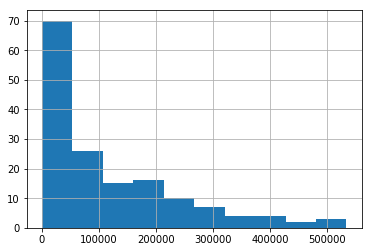

In [29]:
_ = pd.value_counts(all_properties).hist()

In [30]:
pd.value_counts(all_properties).tail()

hostal (es)     3282
camping site    2526
szep kartya     1533
kosher food     1248
water slide      349
dtype: int64

In [31]:
unique_properties = list(set(all_properties))
property2natural = {v: k for k, v in enumerate(unique_properties)}
del all_properties
gc.collect()

26

In [32]:
n_properties = len(unique_properties)
n_properties

157

In [33]:
meta_df['properties'] = meta_df['properties'].apply(lambda ps: [property2natural[p] for p in ps])

In [34]:
meta_df['properties'] = meta_df['properties'].apply(lambda ps: np.sum(np.eye(n_properties, dtype=int)[ps], axis=0))

In [35]:
meta_mapping = dict(meta_df[['item_id', 'properties']].values)

In [36]:
# add a mapping for the padded values
# meta_mapping[0] = np.zeros(n_properties, dtype=int)

In [37]:
del meta_df, unique_properties, property2natural
gc.collect()

0

---

In [38]:
%%time
train['impressions'] = (train['impressions']
                        .apply(lambda imps: np.vstack([meta_mapping[i] 
                                                      if i in meta_mapping.keys()
                                                      else np.zeros(n_properties, dtype=int) 
                                                      for i in imps])))
del meta_mapping
gc.collect()

CPU times: user 5.95 s, sys: 576 ms, total: 6.52 s
Wall time: 6.52 s


---

In [39]:
# current_filters
all_cfs = np.concatenate(train['cfs'].dropna().values)
pd.value_counts(all_cfs).head()

sort by price        6623
focus on distance    4466
hotel                3778
5 star               2995
4 star               2858
dtype: int64

In [40]:
pd.value_counts(all_cfs, normalize=True).cumsum().head()

sort by price        0.142048
focus on distance    0.237834
hotel                0.318863
5 star               0.383099
4 star               0.444397
dtype: float64

In [41]:
unique_cfs = list(set(all_cfs))
cfs_mapping = {v: k for k, v in enumerate(unique_cfs)}
n_cfs = len(unique_cfs)
n_cfs

99

In [42]:
train.loc[train['cfs'].notna(), 'cfs'] = (train.loc[train['cfs'].notna(), 'cfs']
                                          .apply(lambda cfs: [cfs_mapping[cf] for cf in cfs]))

In [43]:
%%time
train['cfs'] = (train['cfs'].apply(lambda cfs: np.sum(np.eye(n_cfs, dtype=int)[cfs], axis=0) 
                                   if type(cfs) ==list else np.zeros(n_cfs, dtype=int)))

CPU times: user 353 ms, sys: 4.74 ms, total: 358 ms
Wall time: 357 ms


In [44]:
del cfs_mapping
gc.collect()

0

---

---

In [45]:
# encode city, platform and device
def categorize(df, cols):
    for col in cols:
        print('converting', col)
        unique_values = df[col].unique()
        mapping = {v: k for k, v in enumerate(unique_values)}
        df[col] = df[col].map(mapping)
        
categorize(train, ['city', 'platform', 'device', 'country'])

converting city
converting platform
converting device
converting country


In [46]:
train['device'].unique()

array([0, 1, 2])

In [47]:
train = pd.get_dummies(train, columns=['device'], drop_first=True)

In [48]:
# # look at price distribution
# all_prices = np.concatenate(train.prices.values)
# _= plt.hist(all_prices, bins=20)

In [49]:
# np.max(all_prices), np.min(all_prices[all_prices!=0]), np.mean(all_prices), np.median(all_prices)

In [50]:
# _= plt.hist(np.log1p(all_prices), bins=20)

In [51]:
# m = np.mean(np.log1p(all_prices))
# sd = np.std(np.log1p(all_prices))
# _ = plt.hist((np.log1p(all_prices)-m)/sd)

In [52]:
# maybe normalize to percentage within each records, check does each item_id have the same price over all records
def normalize(ps):
    p_arr = np.array(ps)
    return p_arr/(p_arr.max())

train['prices'] = train['prices'].apply(normalize)
prices = np.array(list(train['prices'].values))
del train['prices']

In [53]:
# # IMPRESSIONS
# impressions = np.array(list(train['impressions'].values))
# # map each item_id to integer value
# # impressions = np.array([[imps_mapping[j] for j in i] for i in impressions])
# del train['impressions']
# CURRENT_FILTERS
cfilters = np.array(list(train['cfs'].values))
del train['cfs']
# record no_reorder info
no_reorders = train['no_reorder'].values
del train['no_reorder']
# CITY
cities = train['city'].values
n_city = train['city'].nunique()
del train['city']
# COUNTRY
countries = train['country'].values
n_country = train['country'].nunique()
del train['country']
# PLATFORM
platforms = train['platform'].values
n_plat = train['platform'].nunique()
del train['platform']
# DEVICES
devices = train[['device_1', 'device_2']].values
del train['device_1'], train['device_2']

# SESSION_ID
sids = train['session_id'].values
del train['session_id']
# TARGETS
targets = train['target'].values
del train['target']

# IMPRESSIONS
impressions = np.array(list(train['impressions'].values))
del train['impressions']

In [67]:
def iterate_minibatches(no_reorders, impressions, prices, cfilters, cities, countries, platforms, devices, 
                        batchsize, targets, shuffle=True, reorder=True):
    # default we will shuffle
    indices = np.arange(len(targets))
    while True:
        if shuffle:
            np.random.shuffle(indices)
        for start_idx in range(0, len(targets), batchsize):
            excerpt = indices[start_idx:start_idx+batchsize]
            nos = ~no_reorders[excerpt]
#             print(f'allowed reorder:{nos.sum()}')
            imps = impressions[excerpt]
            ps = prices[excerpt]
            cfs = cfilters[excerpt]
            cis = cities[excerpt]
            cos = countries[excerpt]
            plats = platforms[excerpt]
            ds = devices[excerpt]
            ys = targets[excerpt]
#             print(ys)
            if reorder and np.sum(nos) != 0:
                re_imps = imps[nos]
                re_ps = ps[nos]
                re_cfs = cfs[nos]
                re_cis = cis[nos]
                re_cos = cos[nos]
                re_plats = plats[nos]
                re_ds = ds[nos]
                re_ys = ys[nos]

                # randomly shuffle the order of the impressions and prices
                reorder_ind = ([np.random.choice(np.arange(25, dtype='int'), 25, replace=False) 
                                for _ in range(len(re_imps))])
#                 print([i[0] for i in reorder_ind])
                reorder_imp = re_imps[np.arange(re_imps.shape[0])[:, None], reorder_ind]
                reorder_price = re_ps[np.arange(re_ps.shape[0])[:, None], reorder_ind]
#                 reorder_ys = re_ys[np.arange(re_ys.shape[0]), reorder_ind]
                reorder_ys = [reorder_ind[i][re_ys[i]] for i in range(len(reorder_ind))]
#                 print(reorder_ys)
        
                # concatenate them back
                yield ([np.vstack((imps, reorder_imp)),
                        np.vstack((ps, reorder_price))[:, :, None],
                        np.vstack((cfs, re_cfs)),
                        np.hstack((cis, re_cis)), 
                        np.hstack((cos, re_cos)), 
                        np.hstack((plats, re_plats)),
                        np.vstack((ds, re_ds))],
#                        np.vstack((ys, reorder_ys)))
                       np.hstack((ys, reorder_ys)))
            else:
                yield ([imps, ps[:, :, None], cfs, cis, cos, plats, ds], ys)

In [55]:
# from sklearn.metrics import roc_auc_score
# from keras.callbacks import Callback

# class Mrr(Callback):
#     def __init__(self, validation_data=validation_data, interval=2):
#         super(Callback, self).__init__()
#         self.interval = interval
#         self.X_val, self.y_val = validation_data
#         self.y_val = y_val

#     def on_epoch_end(self, epoch, logs={}):
#         if epoch % self.interval == 0:
#             y_pred = self.model.predict_generator(self.val_gen, verbose=0)
#             val_mrr = np.mean(1/(np.where(np.argsort(y_pred)[:, ::-1] == y_val[val_pred.shape[0]].reshape(-1, 1))[1]+1))
#             print("interval evaluation - epoch: {:d} - score: {:.6f}".format(epoch, val_mrr))

In [56]:
# a = np.random.randint(0, 10, 10)
# a

In [57]:
# b = [np.random.choice(np.arange(25, dtype='int'), 25, replace=False) 
#                                 for _ in range(len(a))]
# b

In [58]:
# [b[i][a[i]] for i in range(len(a))]

In [59]:
def nemd(n):
    return int(n**(1/4))

In [60]:
nemd(n_city), nemd(n_country), nemd(n_plat)

(7, 3, 2)

In [61]:
# create data generator [imps, ps, cis, cos, plats, ds], ys
# train_gen = iterate_minibatches(trn_no, trn_imp, trn_price, trn_cfilter, trn_city, trn_country, 
#                                 trn_plat, trn_dev, batch_size, train_y_binary, shuffle=True, reorder=True)

# create data generator [imps, ps, cis, cos, plats, ds], ys
# train_gen = iterate_minibatches(trn_no, trn_imp, trn_price, trn_cfilter, trn_city, trn_country, 
#                                 trn_plat, trn_dev, batch_size, y_trn, shuffle=True, reorder=True)

# val_gen = iterate_minibatches(val_no, val_imp, val_price, val_cfilter, val_city, val_country, 
#                               val_plat, val_dev, batch_size, val_y_binary, shuffle=False, reorder=False)

In [62]:
# for i in train_gen:
#     for j in i[0]:
#         print(j.shape)
#     break

In [63]:
# for i in val_gen:
#     for j in i[0]:
#         print(j.shape)
#     print('===', i[1].shape)
#     break

In [64]:
# for c in [trn_imp, trn_price, trn_cfilter, trn_city, trn_country, trn_plat, trn_dev]:
#     print(c.shape)

In [65]:
n_uniques = {'city': n_city, 'country': n_country, 'cfilter': n_cfs, 'platform': n_plat}
n_uniques

{'city': 3413, 'country': 134, 'cfilter': 99, 'platform': 55}

In [69]:
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from sklearn.model_selection import StratifiedKFold
from datetime import datetime as dt
from nn_model import build_model
from keras.utils import plot_model

batch_size = 128
# n_repeat = 2
n_epochs = 2

skf = StratifiedKFold(n_splits=6)

for trn_ind, val_ind in skf.split(targets, targets):
    trn_no, val_no = no_reorders[trn_ind], no_reorders[val_ind]
    trn_imp, val_imp = impressions[trn_ind], impressions[val_ind]
    trn_price, val_price = prices[trn_ind], prices[val_ind]
    trn_cfilter, val_cfilter = cfilters[trn_ind], cfilters[val_ind]
    trn_city, val_city = cities[trn_ind], cities[val_ind]
    trn_country, val_country = countries[trn_ind], countries[val_ind]
    trn_plat, val_plat = platforms[trn_ind], platforms[val_ind]
    trn_dev, val_dev = devices[trn_ind], devices[val_ind]
    
    y_trn, y_val = targets[trn_ind], targets[val_ind]
    # keras requires 0, 1 binary label input
#     from keras.utils import to_categorical
#     train_y_binary = to_categorical(y_trn)
#     val_y_binary = to_categorical(y_val)
    
    
    # create data generator [imps, ps, cis, cos, plats, ds], ys
    train_gen = iterate_minibatches(trn_no, trn_imp, trn_price, trn_cfilter, trn_city, trn_country, 
                                    trn_plat, trn_dev, batch_size, y_trn, shuffle=True, reorder=True)
    
    val_gen = iterate_minibatches(val_no, val_imp, val_price, val_cfilter, val_city, val_country, 
                                  val_plat, val_dev, batch_size, y_val, shuffle=False, reorder=False)
#     TEMP
#     del impressions, prices, cities, platforms, devices
#     gc.collect()
    
    # =====================================================================================
    # create model
    model = build_model(n_uniques, conv1d_filter_size=5)
    
    # print out model info
    nparams = model.count_params()
    print((f'train len: {len(y_trn):,} | val len: {len(y_val):,} '
           f'| numer of parameters: {nparams:,} | train_len/nparams={len(y_trn)/nparams:.5f}'))
    print(model.summary())
    plot_model(model, to_file='model.png')
    # add some callbacks
    callbacks = []
    model_file = 'test.model'
    callbacks = [ModelCheckpoint(model_file, save_best_only=True, verbose=1)]
    log_dir = "logs/{}".format(dt.now().strftime('%m-%d-%H-%M'))
    tb = TensorBoard(log_dir=log_dir, write_graph=True, write_grads=True)
    callbacks.append(tb)
    # simple early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', patience=20, verbose=1)
    callbacks.append(es)
    # rp
    rp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=20, verbose=1)

    # add mrr callback
#     callbacks.append(IntervalEvaluation())
    
    history = model.fit_generator(train_gen, 
                                  steps_per_epoch=len(y_trn)//batch_size, 
                                  epochs=n_epochs, 
                                  verbose=1,
                                  callbacks=callbacks, 
                                  validation_data=val_gen, 
                                  validation_steps=len(y_val)//batch_size)

    # make prediction
    trn_pred = model.predict(x=[trn_imp, trn_price[:, :, None], trn_cfilter, 
                                trn_city, trn_country, trn_plat, trn_dev], 
                             batch_size=1024)
    trn_pred_label = np.where(np.argsort(trn_pred)[:, ::-1] == y_trn.reshape(-1, 1))[1]
    trn_mrr = np.mean(1/(trn_pred_label+1))

    val_pred = model.predict(x=[val_imp, val_price[:, :, None], val_cfilter, 
                                val_city, val_country, val_plat, val_dev], 
                             batch_size=1024)
    val_pred_label = np.where(np.argsort(val_pred)[:, ::-1] == y_val.reshape(-1, 1))[1]
    val_mrr = np.mean(1/(val_pred_label+1))
    print(f'train mrr: {trn_mrr:.2f} | val mrr: {val_mrr:.2f}')
    
    break

train len: 74,485 | val len: 14,907 | numer of parameters: 59,891 | train_len/nparams=1.24368
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
impression_input (InputLayer)   (None, 25, 157)      0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 21, 16)       12576       impression_input[0][0]           
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 21, 16)       64          conv1d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling1d_1 (MaxPooling1D)  (None, 10, 16)       0           batch_normalization_1[0][0]      
_______________

Epoch 1/2
581/581 [==============================] - 16s 27ms/step - loss: 3.0357 - acc: 0.1765 - val_loss: 2.6802 - val_acc: 0.3087

Epoch 00001: val_loss improved from inf to 2.68017, saving model to test.model
Epoch 2/2
581/581 [==============================] - 15s 26ms/step - loss: 2.9720 - acc: 0.1847 - val_loss: 2.6787 - val_acc: 0.3093

Epoch 00002: val_loss improved from 2.68017 to 2.67868, saving model to test.model
train mrr: 0.45 | val mrr: 0.45


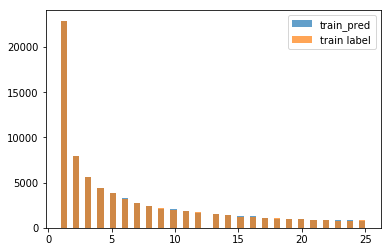

In [70]:
_ = plt.hist(trn_pred_label, bins=50, label='train_pred', alpha=0.7)
_ = plt.hist(y_trn+1, bins=50, label = 'train label', alpha=0.7)
_ = plt.legend()

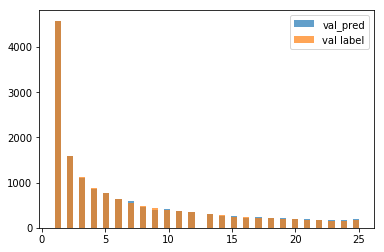

In [71]:
_ = plt.hist(val_pred_label, bins=50, label='val_pred', alpha=0.7)
_ = plt.hist(y_val+1, bins=50, label = 'val label', alpha=0.7)
_ = plt.legend()

In [ ]:
# train mrr: 0.47 | val mrr: 0.45

In [ ]:
# add mrr at per epochs probably
# look at no embeddings

In [114]:
mat.head()

y_true,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
prediction,,,,,,,,,,,,,,,,,,,,,
0,4575.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10.0,1568.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,9.0,1057.0,16.0,14.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,54.0,407.0,374.0,3.0,7.0,1.0,0.0,0.0,...,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,6.0,325.0,338.0,53.0,28.0,9.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [119]:
(mat.div(mat.sum(axis=1), axis=0) ).sum(axis=1)

prediction
0     1.0
1     1.0
2     1.0
3     1.0
4     1.0
5     1.0
6     1.0
7     1.0
8     1.0
9     1.0
10    1.0
11    1.0
12    1.0
13    1.0
14    1.0
15    1.0
16    1.0
17    1.0
18    1.0
19    1.0
20    1.0
21    1.0
22    1.0
23    1.0
24    1.0
dtype: float64

In [115]:
mat.sum(axis=1)

prediction
0     4579.0
1     1581.0
2     1096.0
3      854.0
4      765.0
5      648.0
6      589.0
7      457.0
8      400.0
9      416.0
10     362.0
11     349.0
12     303.0
13     271.0
14     264.0
15     216.0
16     242.0
17     210.0
18     206.0
19     188.0
20     184.0
21     179.0
22     181.0
23     179.0
24     188.0
dtype: float64

In [123]:
def confusion_matrix(y_pred, y_true, normalize='row', level=0, log_scale=False):
    compare = pd.DataFrame({'prediction': y_pred, 'y_true': y_true})
    counts = compare.groupby('y_true')['prediction'].value_counts()
    mat = counts.unstack(level=0)
    mat.fillna(0, inplace=True)
    
    if normalize == 'row':
        row_sum = mat.sum(axis=1)
        mat = mat.div(row_sum, axis=0)
        log_scale = False
    elif normalize == 'column':
        col_sum = mat.sum(axis=0)
        mat = mat.div(col_sum, axis=1)
        log_scale = False
    # plot
    fig = plt.figure(figsize=(35,10))
    ax = fig.add_subplot(111)
    if log_scale:
        cax = ax.matshow(np.log1p(mat), interpolation='nearest')#, cmap='coolwarm')#, aspect='auto')
    else:
        cax = ax.matshow(mat, interpolation='nearest')#, cmap='coolwarm')#, aspect='auto')
    fig.colorbar(cax)
    ax.set_xlabel(f'{mat.columns.name}')
    ax.xaxis.set_label_position('top') 
    ax.set_ylabel(f'{mat.index.name}')
    
    ax.set_xticks(np.arange(mat.shape[1]))
    ax.set_xticklabels(list(mat.columns.astype(str)), rotation=90)
    ax.set_yticks(np.arange(mat.shape[0]))
    _ = ax.set_yticklabels(list(mat.index.astype(str)))
    return mat

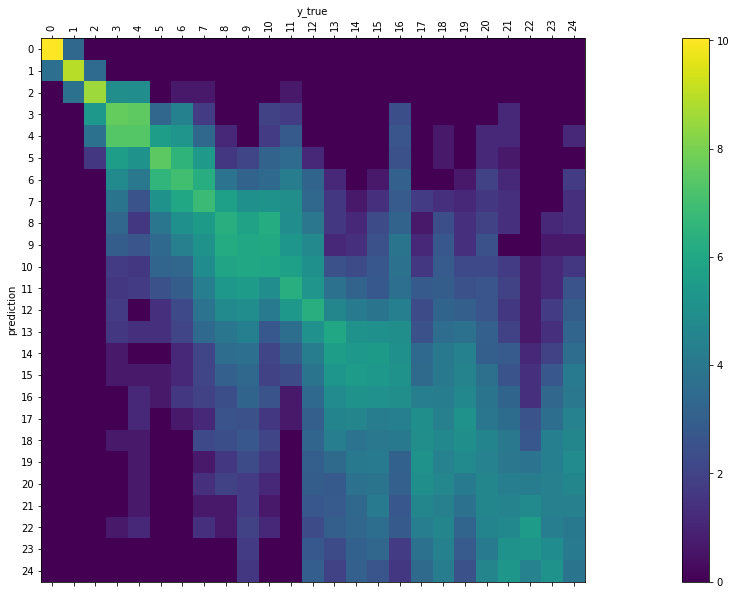

In [125]:
mat = confusion_matrix(trn_pred_label, y_trn, normalize=False, level=0, log_scale=True)


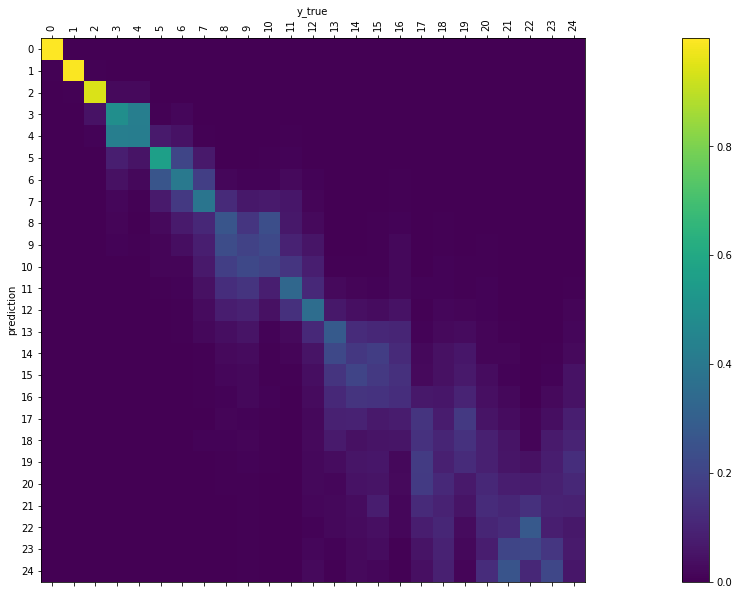

In [126]:
mat = confusion_matrix(trn_pred_label, y_trn, normalize='row')


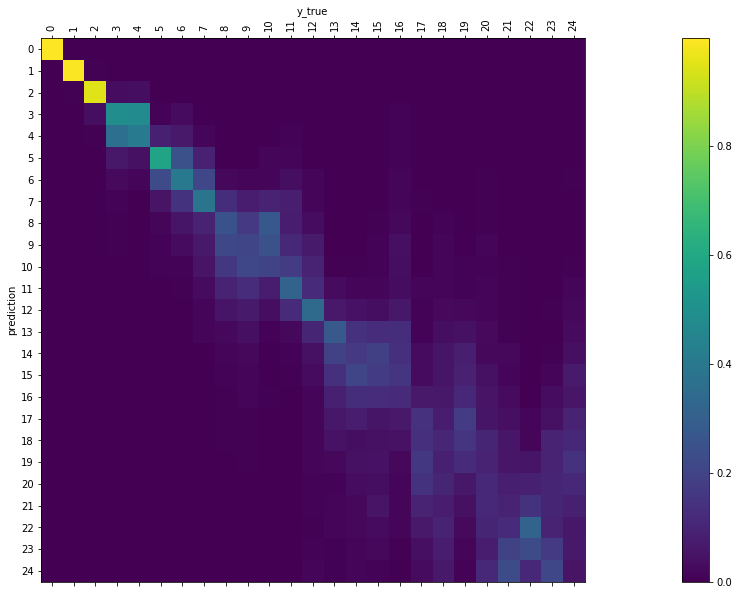

In [127]:
mat = confusion_matrix(trn_pred_label, y_trn, normalize='column')

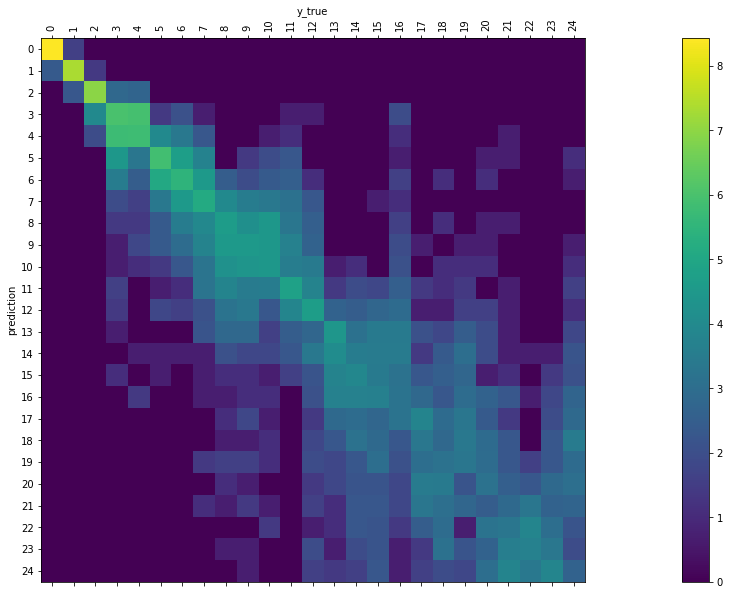

In [110]:
mat = confusion_matrix(val_pred_label, y_val, level=0, log_scale=True)